# Inspect FBS Training Data
inspect and vizualize data loading and pre processing

In [1]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
import time
import concurrent.futures
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import imgaug
from imgaug import augmenters as iaa

ROOT_DIR = os.path.abspath('../../')
sys.path.append(ROOT_DIR)
    
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn import model as modellib
from mrcnn.model import log

import fbs

%matplotlib inline

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13029476651863920794
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 60293120
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7786396015386686997
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


## Configuration

In [2]:
DATASET_DIR = os.path.join(ROOT_DIR, 'data/')

# Use configuation from nucleus.py, but override
# image resizing so we see the real sizes here
class NoResizeConfig(fbs.FBSConfig):
    IMAGE_RESIZE_MODE = "none"
    
config = NoResizeConfig()

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Dataset

In [4]:
dataset = fbs.FBSDataset()
dataset.load_data(DATASET_DIR, subset='train')
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

loading data: 100%|██████████| 172/172 [03:07<00:00,  1.03it/s]

Image Count: 6737
Class Count: 2
  0. BG                                                
  1. brain                                             


## Display Samples

[1803 6561  156 4380]


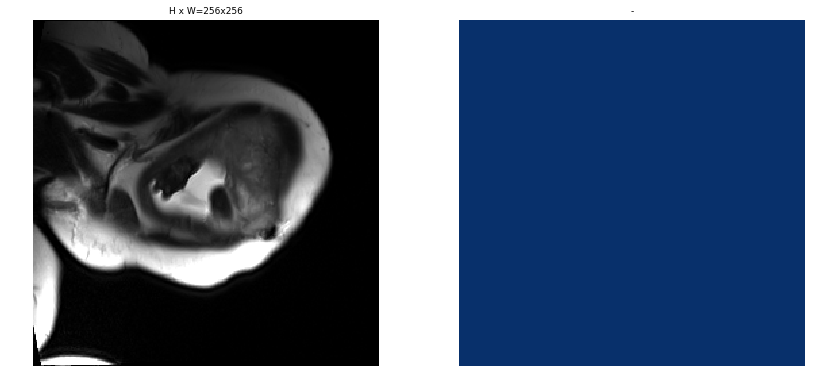

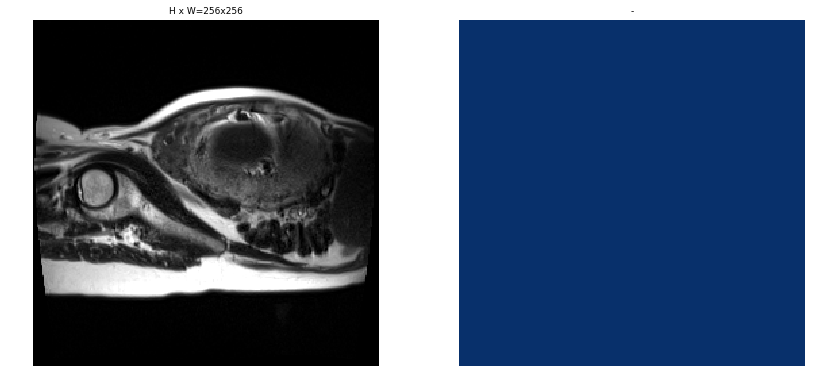

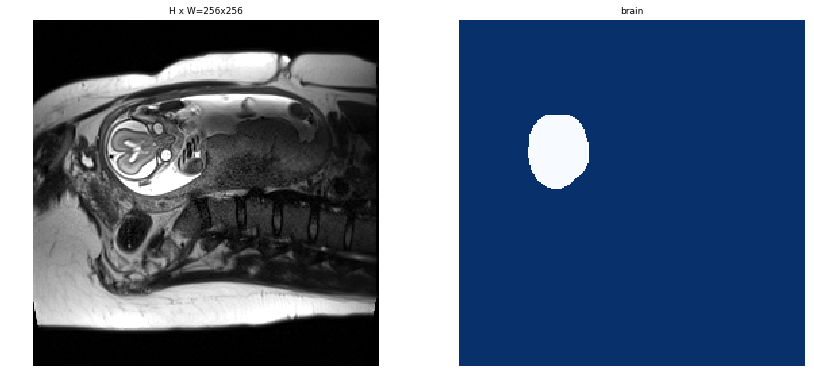

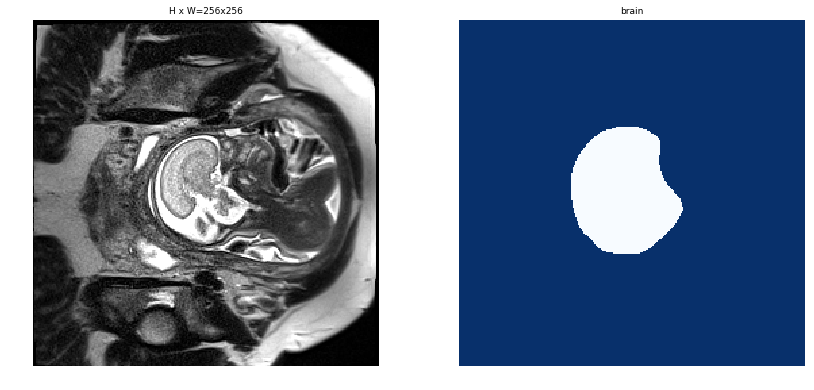

In [5]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
print(image_ids)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=1)

molded_image             shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint16
mask                     shape: (256, 256, 1)         min:    0.00000  max:  255.00000  uint16


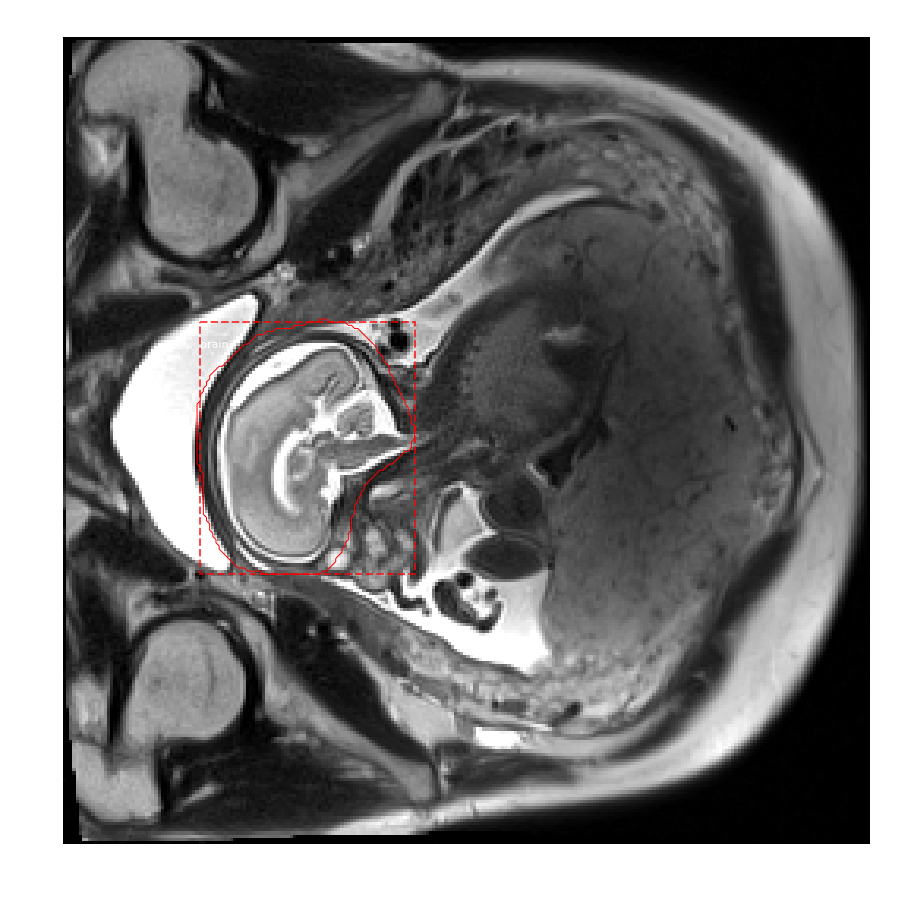

In [6]:
image_id = 2335

# Load and display
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
        dataset, config, image_id, use_mini_mask=False)
log("molded_image", image)
log("mask", mask)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names,
                            show_bbox=True)

## Dataset Stats


In [7]:
def image_stats(image_id):
    """Returns a dict of stats for one image."""
    image = dataset.load_image(image_id)
    mask, _ = dataset.load_mask(image_id)
    bbox = utils.extract_bboxes(mask)
    # Sanity check
    assert mask.shape[:2] == image.shape[:2]
    # Return stats dict
    return {
        "id": image_id,
        "shape": list(image.shape),
        "bbox": [[b[2] - b[0], b[3] - b[1]]
                 for b in bbox
                 # Uncomment to exclude nuclei with 1 pixel width
                 # or height (often on edges)
                 # if b[2] - b[0] > 1 and b[3] - b[1] > 1
                ],
        "color": np.mean(image, axis=(0, 1)),
    }

# Loop through the dataset and compute stats over multiple threads
# This might take a few minutes
t_start = time.time()
with concurrent.futures.ThreadPoolExecutor() as e:
    stats = list(e.map(image_stats, dataset.image_ids))
t_total = time.time() - t_start
print("Total time: {:.1f} seconds".format(t_total))

Total time: 1.6 seconds


## Image Size Stats

Image Count:  6737
Height  mean: 263.16  median: 256.00  min: 232.00  max: 512.00
Width   mean: 263.37  median: 256.00  min: 256.00  max: 512.00
Color   mean (RGB): 73.99 73.99 73.99


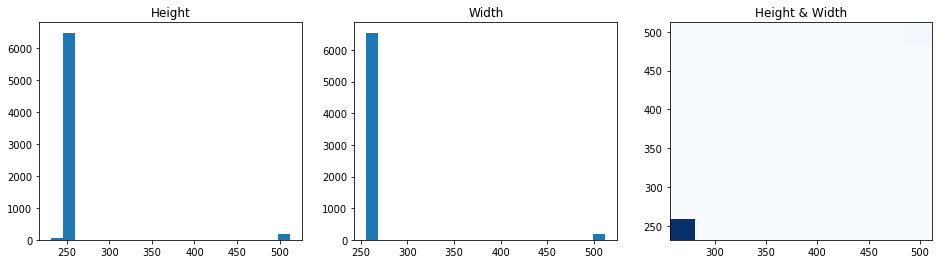

In [8]:

# Image stats
image_shape = np.array([s['shape'] for s in stats])
image_color = np.array([s['color'] for s in stats])
print("Image Count: ", image_shape.shape[0])
print("Height  mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
    np.mean(image_shape[:, 0]), np.median(image_shape[:, 0]),
    np.min(image_shape[:, 0]), np.max(image_shape[:, 0])))
print("Width   mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
    np.mean(image_shape[:, 1]), np.median(image_shape[:, 1]),
    np.min(image_shape[:, 1]), np.max(image_shape[:, 1])))
print("Color   mean (RGB): {:.2f} {:.2f} {:.2f}".format(*np.mean(image_color, axis=0)))

# Histograms
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].set_title("Height")
_ = ax[0].hist(image_shape[:, 0], bins=20)
ax[1].set_title("Width")
_ = ax[1].hist(image_shape[:, 1], bins=20)
ax[2].set_title("Height & Width")
_ = ax[2].hist2d(image_shape[:, 1], image_shape[:, 0], bins=10, cmap="Blues")


## Brain per image stats

Brain/Image
Image area <=  256**2:  mean: 1.0  median: 1.0  min: 1.0  max: 1.0
Image area <=  512**2:  mean: 1.0  median: 1.0  min: 1.0  max: 1.0


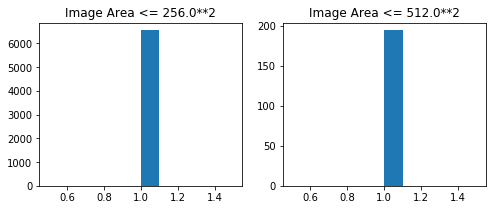

In [9]:
# Segment by image area
image_area_bins = [256**2, 512**2]

print("Brain/Image")
fig, ax = plt.subplots(1, len(image_area_bins), figsize=(8, 3))
area_threshold = 0
for i, image_area in enumerate(image_area_bins):
    brain_per_image = np.array([len(s['bbox']) 
                                 for s in stats 
                                 if area_threshold < (s['shape'][0] * s['shape'][1]) <= image_area])
    area_threshold = image_area
    if len(brain_per_image) == 0:
        print("Image area <= {:4}**2: None".format(np.sqrt(image_area)))
        continue
    print("Image area <= {:4.0f}**2:  mean: {:.1f}  median: {:.1f}  min: {:.1f}  max: {:.1f}".format(
        np.sqrt(image_area), brain_per_image.mean(), np.median(brain_per_image), 
        brain_per_image.min(), brain_per_image.max()))
    ax[i].set_title("Image Area <= {:4}**2".format(np.sqrt(image_area)))
    _ = ax[i].hist(brain_per_image, bins=10)

## Brain Size Stats


Image Area <= 256**2
  Total Nuclei:  6543
  Brain Height. mean: 52.79  median: 61.00  min: 0.00  max: 116.00
  Brain Width.  mean: 49.51  median: 58.00  min: 0.00  max: 104.00
  Brain Area.   mean: 3559.53  median: 3599.00  min: 0.00  max: 11440.00
 Images with no brain 1300
 Images with brain 5243

Image Area <= 512**2
  Total Nuclei:  194
  Brain Height. mean: 100.80  median: 117.50  min: 0.00  max: 178.00
  Brain Width.  mean: 89.31  median: 109.00  min: 0.00  max: 149.00
  Brain Area.   mean: 12014.89  median: 12796.00  min: 0.00  max: 25479.00
 Images with no brain 36
 Images with brain 158


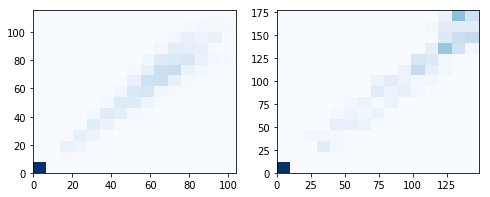

In [10]:
# Brain size stats
fig, ax = plt.subplots(1, len(image_area_bins), figsize=(8, 3))
area_threshold = 0

for i, image_area in enumerate(image_area_bins):
    brain_shape = np.array([
        b 
        for s in stats if area_threshold < (s['shape'][0] * s['shape'][1]) <= image_area
        for b in s['bbox']])
    brain_area = brain_shape[:, 0] * brain_shape[:, 1]
    area_threshold = image_area

    print("\nImage Area <= {:.0f}**2".format(np.sqrt(image_area)))
    print("  Total Nuclei: ", brain_shape.shape[0])
    print("  Brain Height. mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
        np.mean(brain_shape[:, 0]), np.median(brain_shape[:, 0]),
        np.min(brain_shape[:, 0]), np.max(brain_shape[:, 0])))
    print("  Brain Width.  mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
        np.mean(brain_shape[:, 1]), np.median(brain_shape[:, 1]),
        np.min(brain_shape[:, 1]), np.max(brain_shape[:, 1])))
    print("  Brain Area.   mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
        np.mean(brain_area), np.median(brain_area),
        np.min(brain_area), np.max(brain_area)))
    
    print(" Images with no brain {}".format(
        len(np.where(brain_area == 0)[0])))
    
    print(" Images with brain {}".format(
        len(np.nonzero(brain_area)[0])))
    
    # Show 2D histogram
    _ = ax[i].hist2d(brain_shape[:, 1], brain_shape[:, 0], bins=15, cmap="Blues")

## Exclue images without brain

(6543, 2)

Image Area <= 256**2
  Total Images:  6543
  Brain Height. mean: 65.88  median: 68.00  min: 9.00  max: 116.00
  Brain Width.  mean: 61.79  median: 64.00  min: 11.00  max: 104.00
(194, 2)

Image Area <= 512**2
  Total Images:  194
  Brain Height. mean: 123.77  median: 135.00  min: 33.00  max: 178.00
  Brain Width.  mean: 109.66  median: 123.00  min: 29.00  max: 149.00


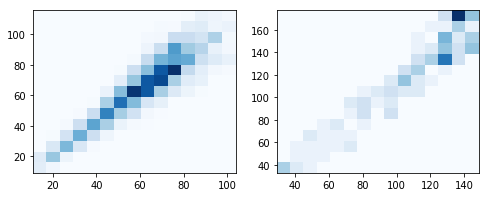

In [11]:
# Brain size stats
fig, ax = plt.subplots(1, len(image_area_bins), figsize=(8, 3))
area_threshold = 0

for i, image_area in enumerate(image_area_bins):
    brain_shape = np.array([
        b 
        for s in stats if area_threshold < (s['shape'][0] * s['shape'][1]) <= image_area
        for b in s['bbox']])
    print(brain_shape.shape)
    
    height = np.array(
        np.take(brain_shape[:, 0], 
                np.nonzero(brain_shape[:, 0])))
    width = np.array(
        np.take(brain_shape[:, 1], 
                np.nonzero(brain_shape[:, 1])))
    
    area_threshold = image_area

    print("\nImage Area <= {:.0f}**2".format(np.sqrt(image_area)))
    print("  Total Images: ", brain_shape.shape[0])
    print("  Brain Height. mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
        np.mean(height), np.median(height),
        np.min(height), np.max(height)))
    print("  Brain Width.  mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
        np.mean(width), np.median(width),
        np.min(width), np.max(width)))
    
    # Show 2D histogram
    _ = ax[i].hist2d(width[0], height[0], bins=15, cmap="Blues")

Brain Aspect Ratio.  mean: 1.12  median: 1.13  min: 0.77  max: 1.43


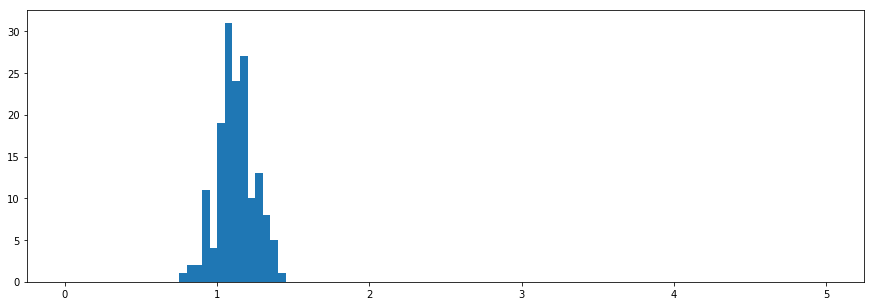

In [12]:
# Nuclei height/width ratio
brain_aspect_ratio = height[0]/ width[0]
print("Brain Aspect Ratio.  mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
    np.mean(brain_aspect_ratio), np.median(brain_aspect_ratio),
    np.min(brain_aspect_ratio), np.max(brain_aspect_ratio)))
plt.figure(figsize=(15, 5))
_ = plt.hist(brain_aspect_ratio, bins=100, range=[0, 5])

## Image Augmentation
Test different augmentation methods

In [13]:
augmentation = iaa.SomeOf((0, 6), [
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.OneOf([iaa.Affine(rotate=90),
               iaa.Affine(rotate=180),
               iaa.Affine(rotate=270)]),
    iaa.Multiply((0.5, 1.5)),
    iaa.GaussianBlur(sigma=(0.0, 2.0))])

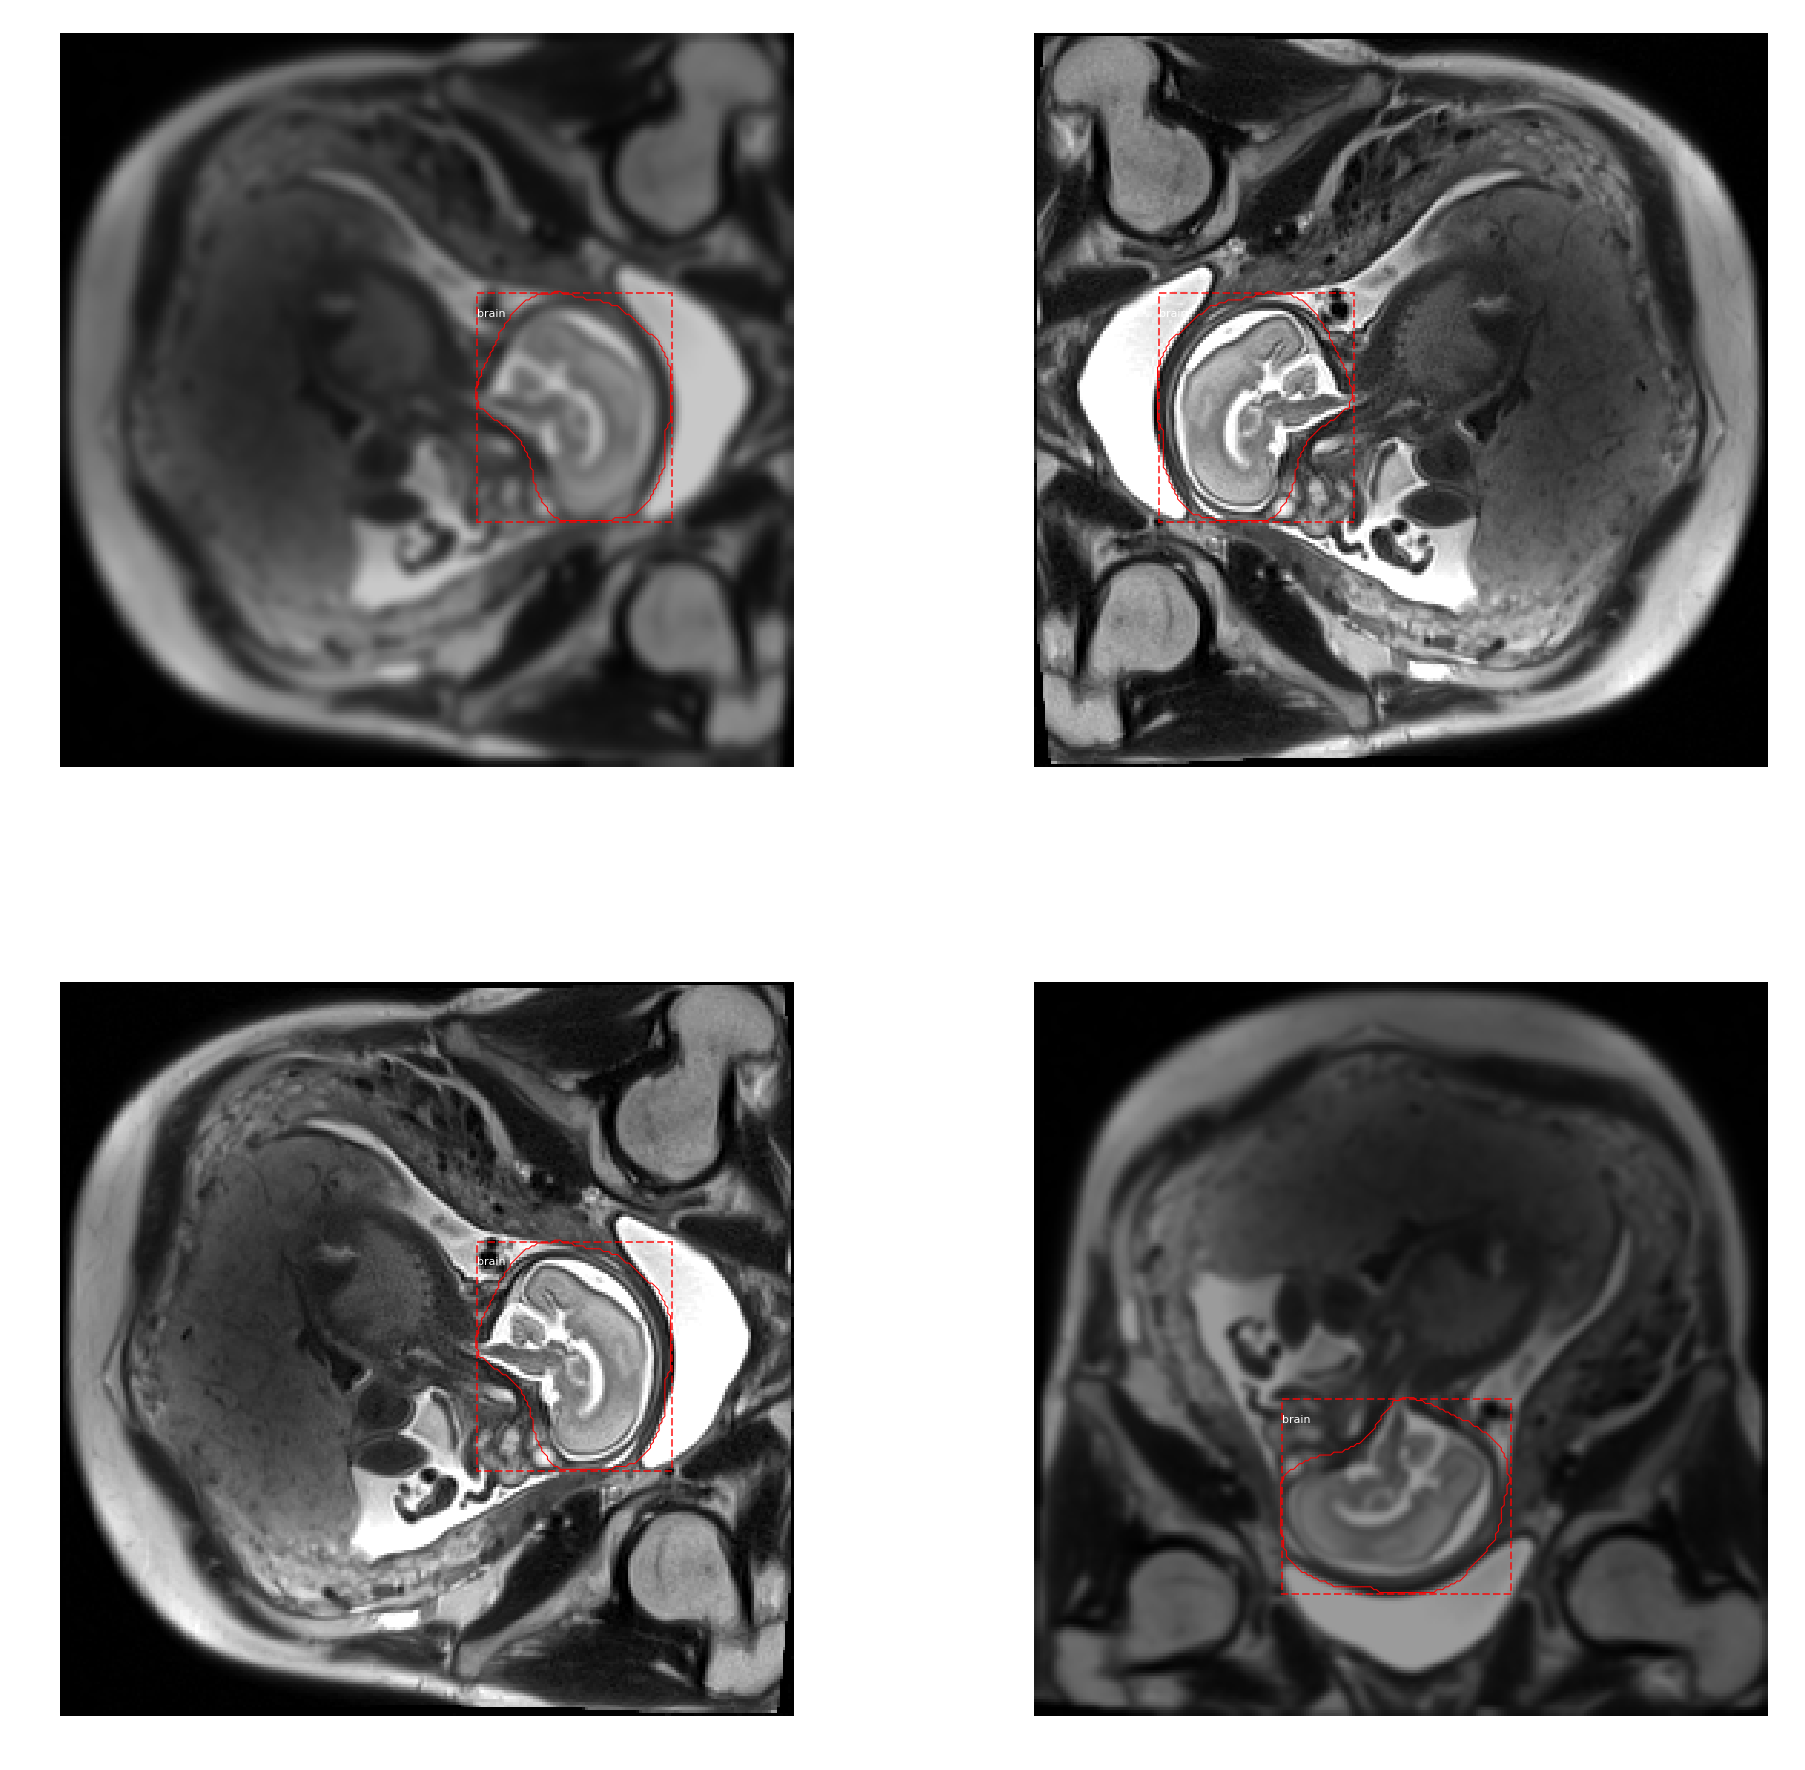

In [15]:
# Load the image multiple times to show augmentations
limit = 4
ax = get_ax(rows=2, cols=limit//2)
for i in range(limit):
    image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
        dataset, config, image_id, use_mini_mask=False, augment=False, augmentation=augmentation)
    
    visualize.display_instances(image, bbox, mask, class_ids,
                                dataset.class_names, ax=ax[i//2, i % 2],
                                show_mask=False, show_bbox=True)

## Image Crops
We dont want to crop images which can hurt performance

In [16]:
class CropConfig(fbs.FBSConfig):
    IMAGE_RESIZE_MODE = "crop"
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
crop_config = CropConfig()

class PadConfig(fbs.FBSConfig):
    IMAGE_RESIZE_MODE = "pad64"
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
pad_config = PadConfig()

class SquareConfig(fbs.FBSConfig):
    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
square_config = SquareConfig()

class NoneConfig(fbs.FBSConfig):
    IMAGE_RESIZE_MODE = "none"
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
none_config = NoneConfig()

CROP


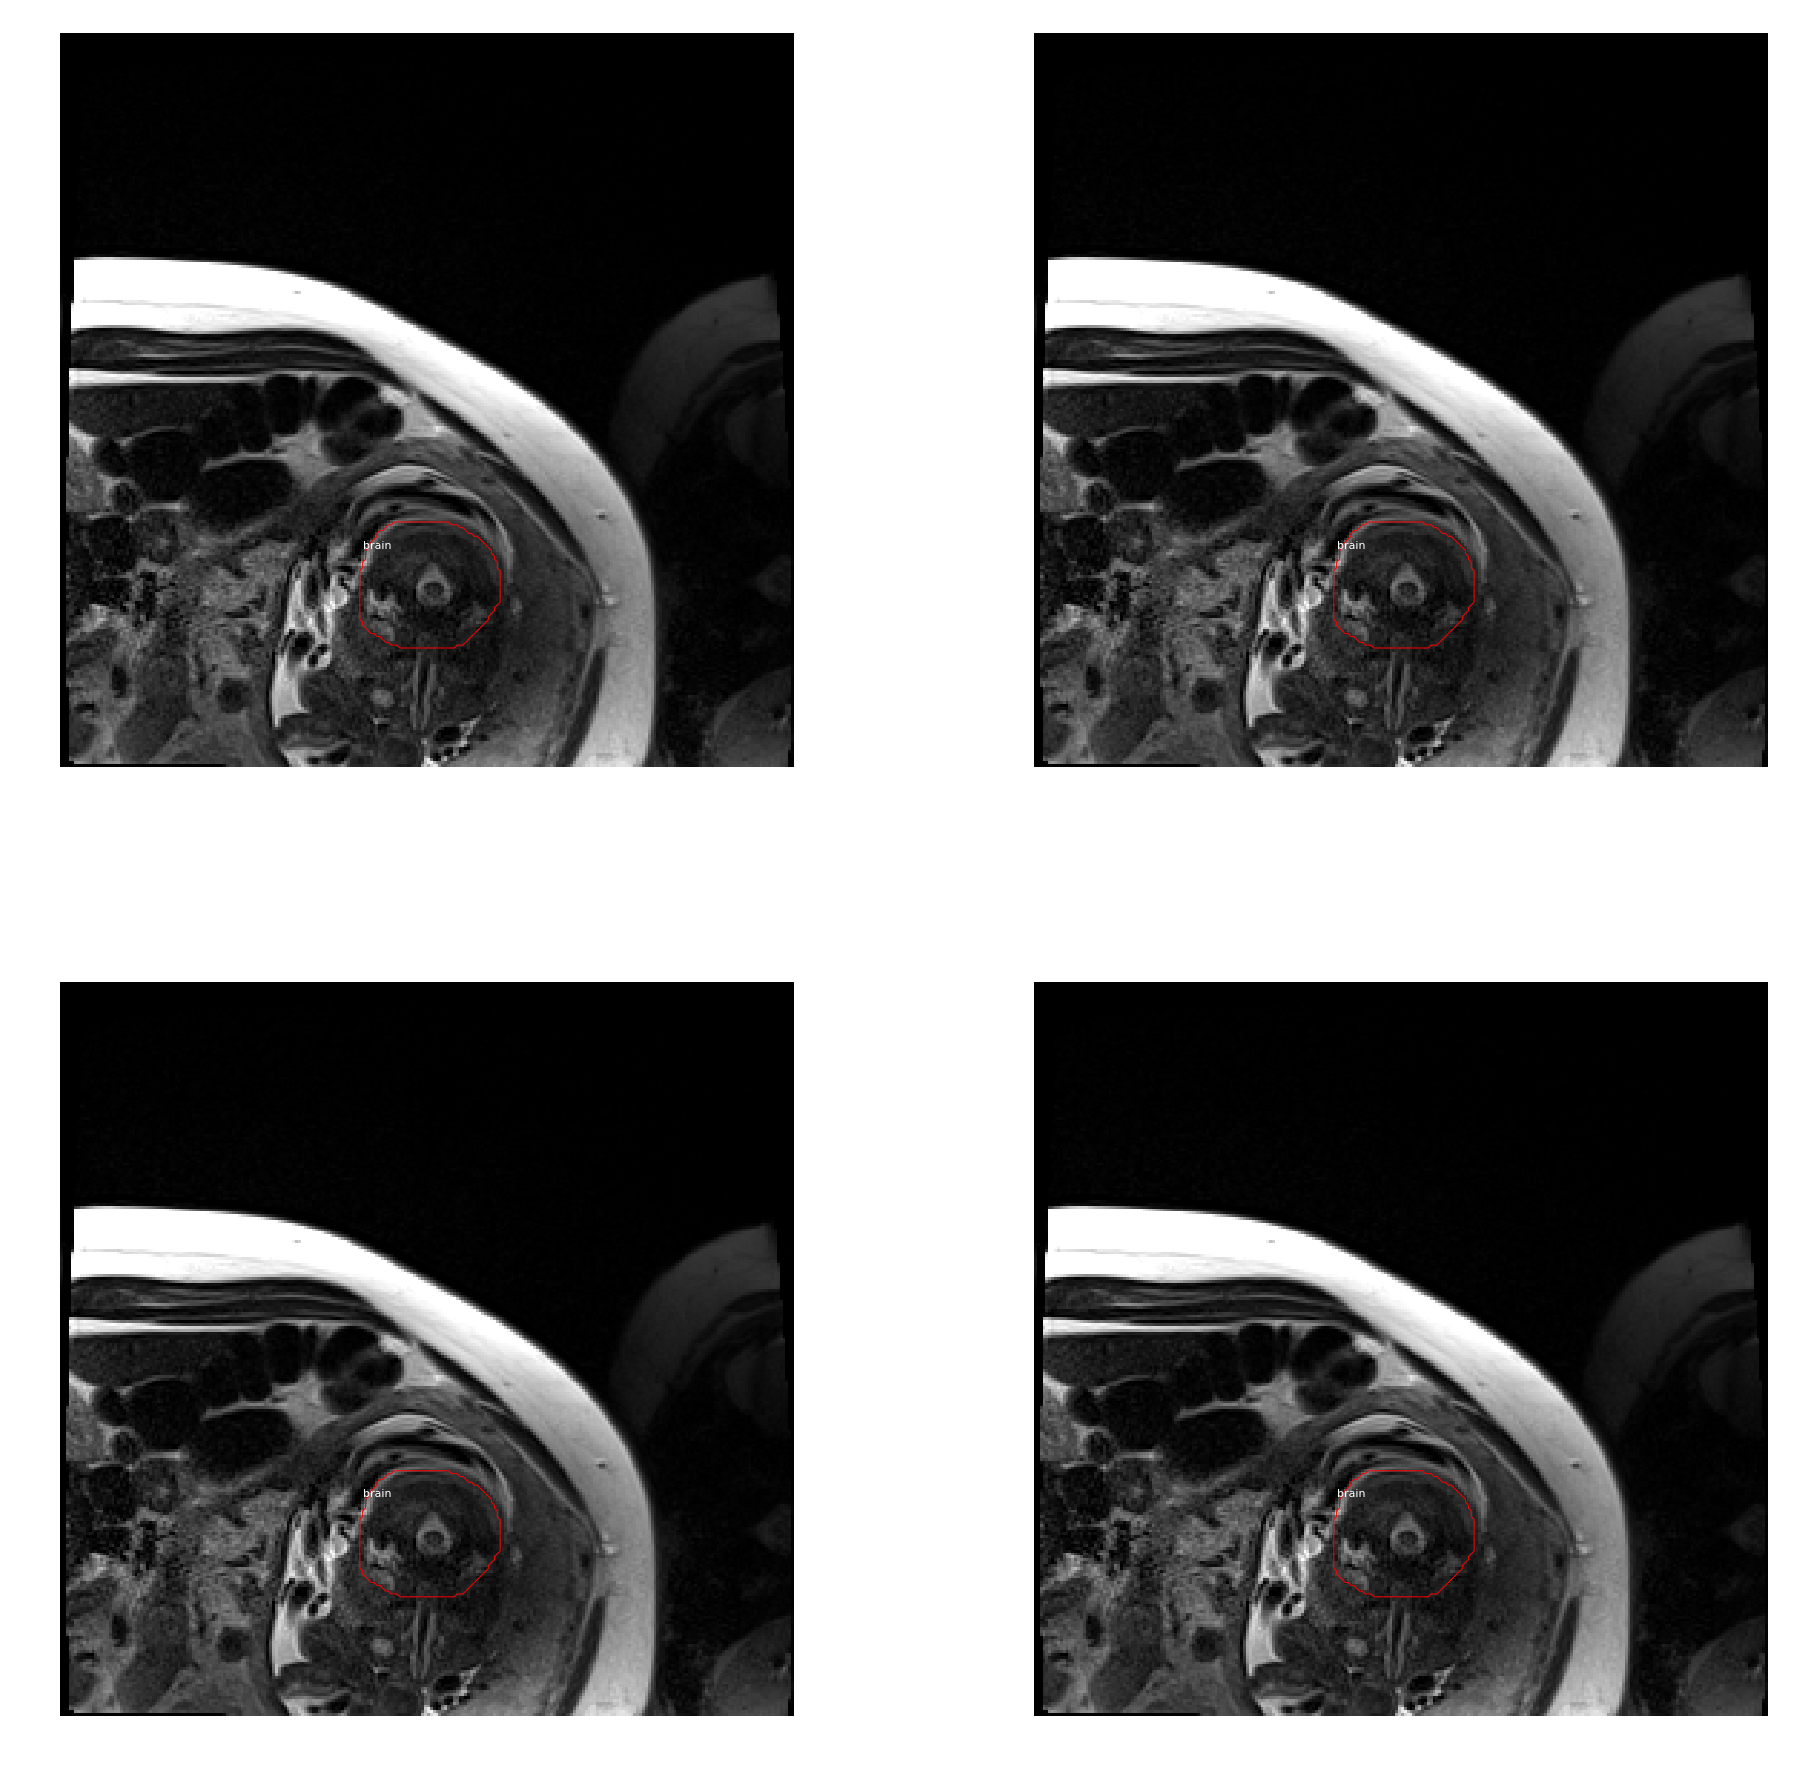

In [21]:
print('CROP')

# Load the image multiple times to show augmentations
limit = 4
image_id = np.random.choice(dataset.image_ids, 1)[0]
ax = get_ax(rows=2, cols=limit//2)
for i in range(limit):
    image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
        dataset, crop_config, image_id, use_mini_mask=False)
    visualize.display_instances(image, bbox, mask, class_ids,
                                dataset.class_names, ax=ax[i//2, i % 2],
                                show_mask=False, show_bbox=False)

Pad


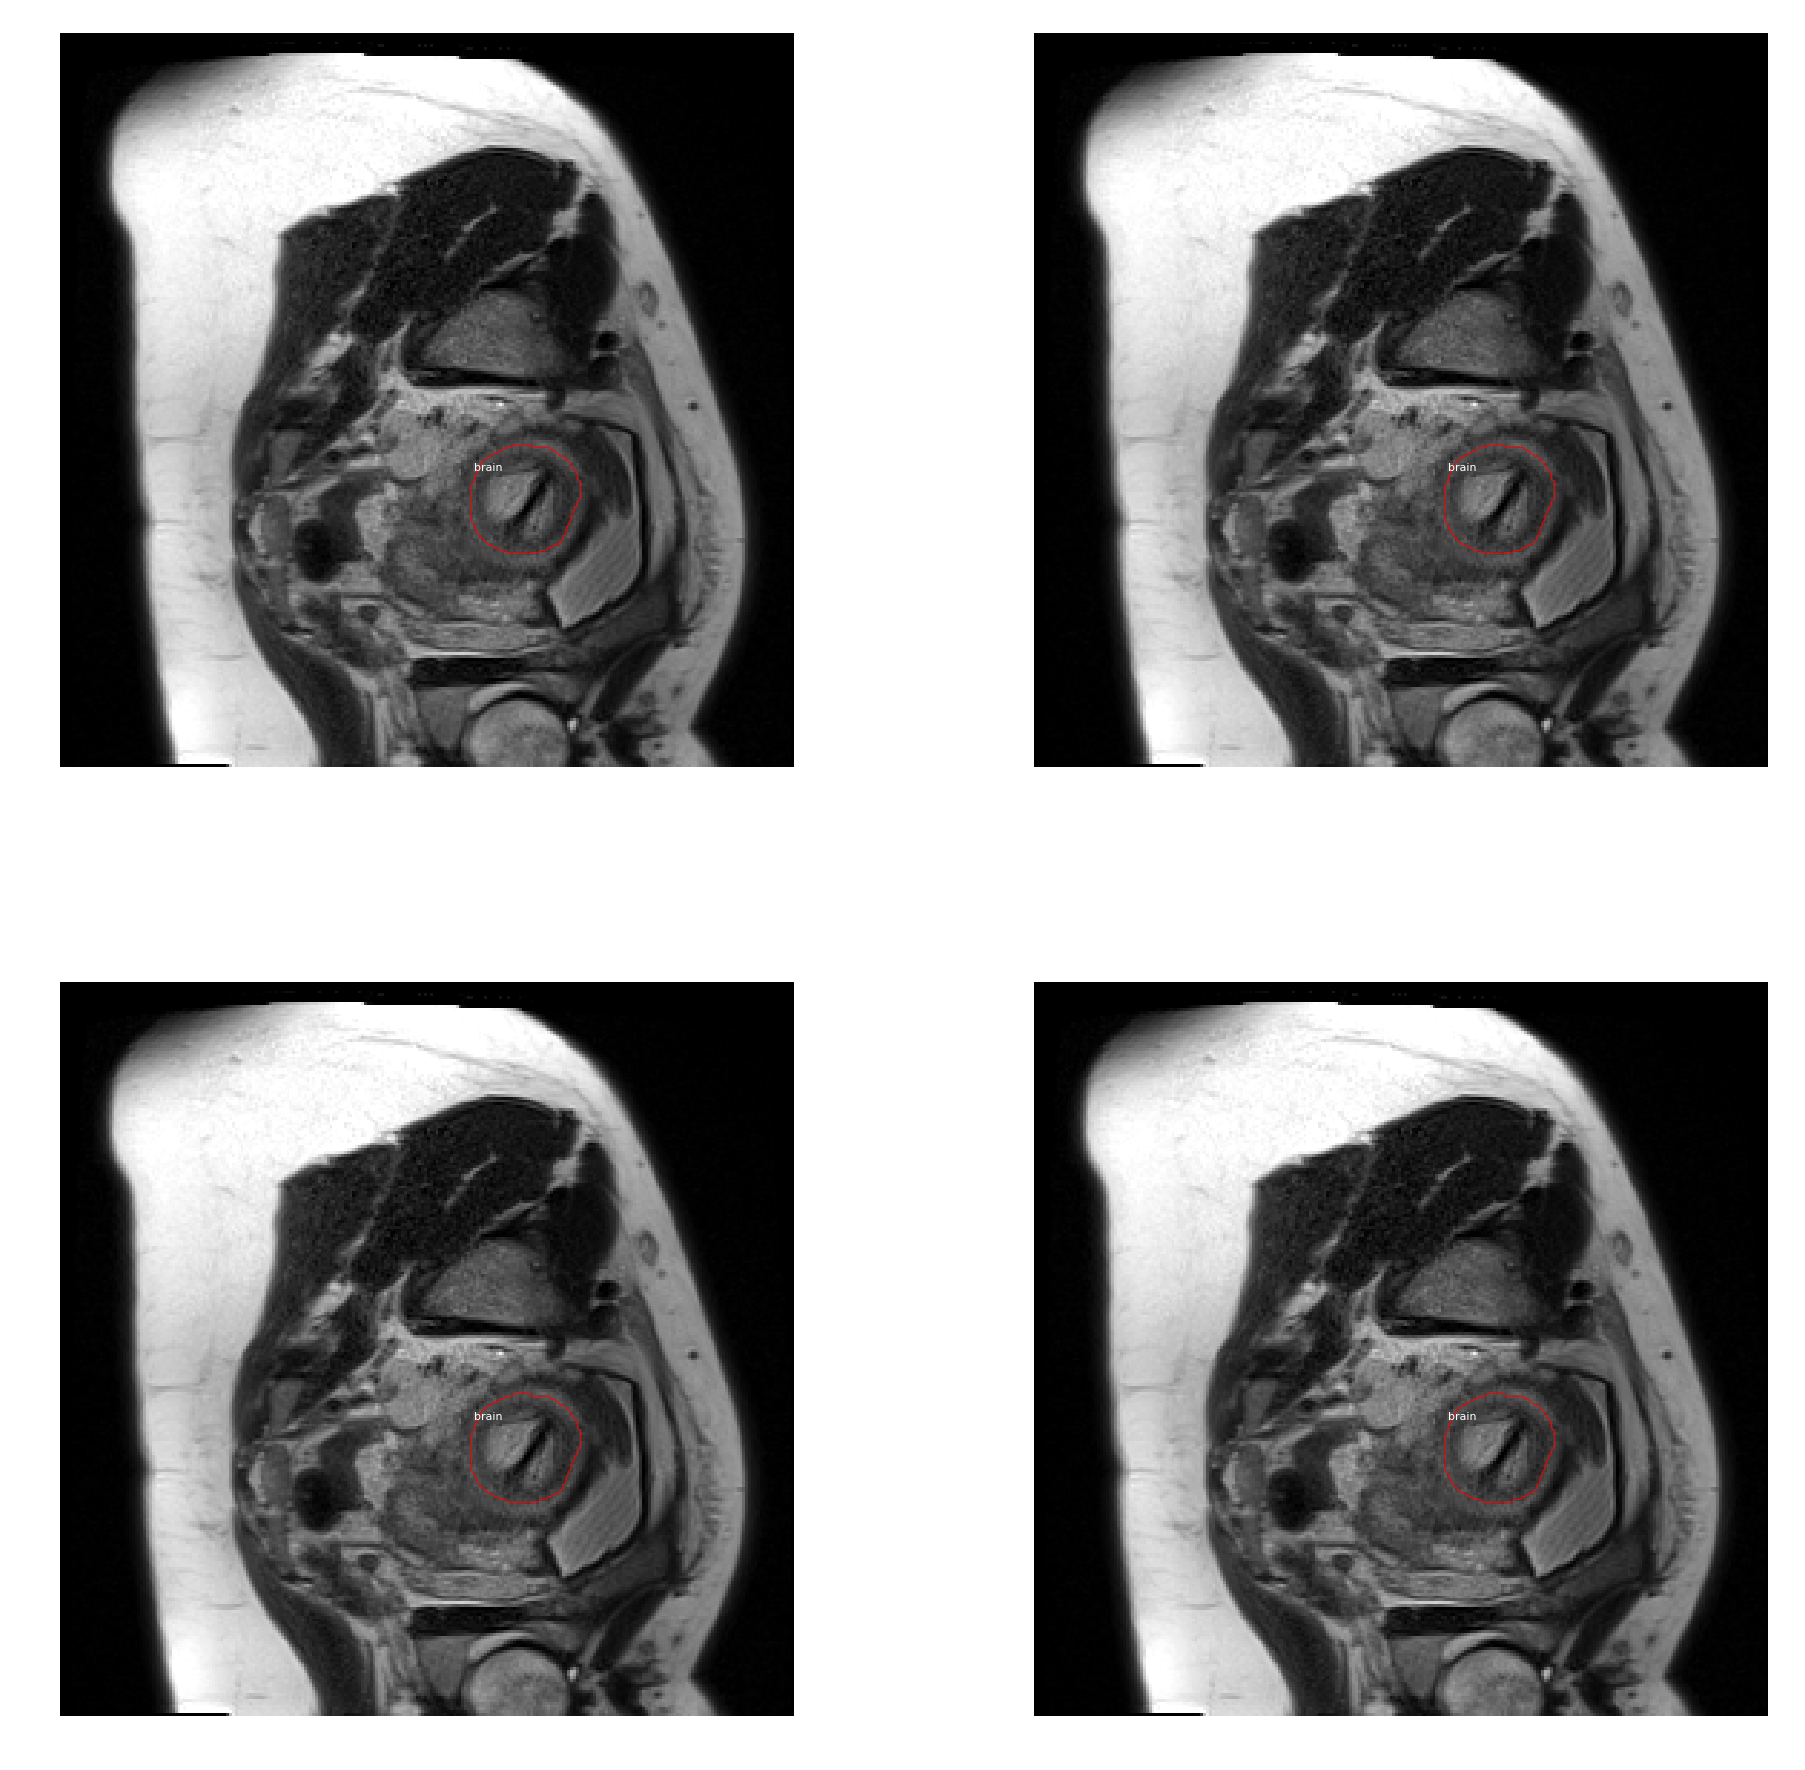

In [22]:
print('Pad')

# Load the image multiple times to show augmentations
limit = 4
image_id = np.random.choice(dataset.image_ids, 1)[0]
ax = get_ax(rows=2, cols=limit//2)
for i in range(limit):
    image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
        dataset, pad_config, image_id, use_mini_mask=False)
    visualize.display_instances(image, bbox, mask, class_ids,
                                dataset.class_names, ax=ax[i//2, i % 2],
                                show_mask=False, show_bbox=False)

square


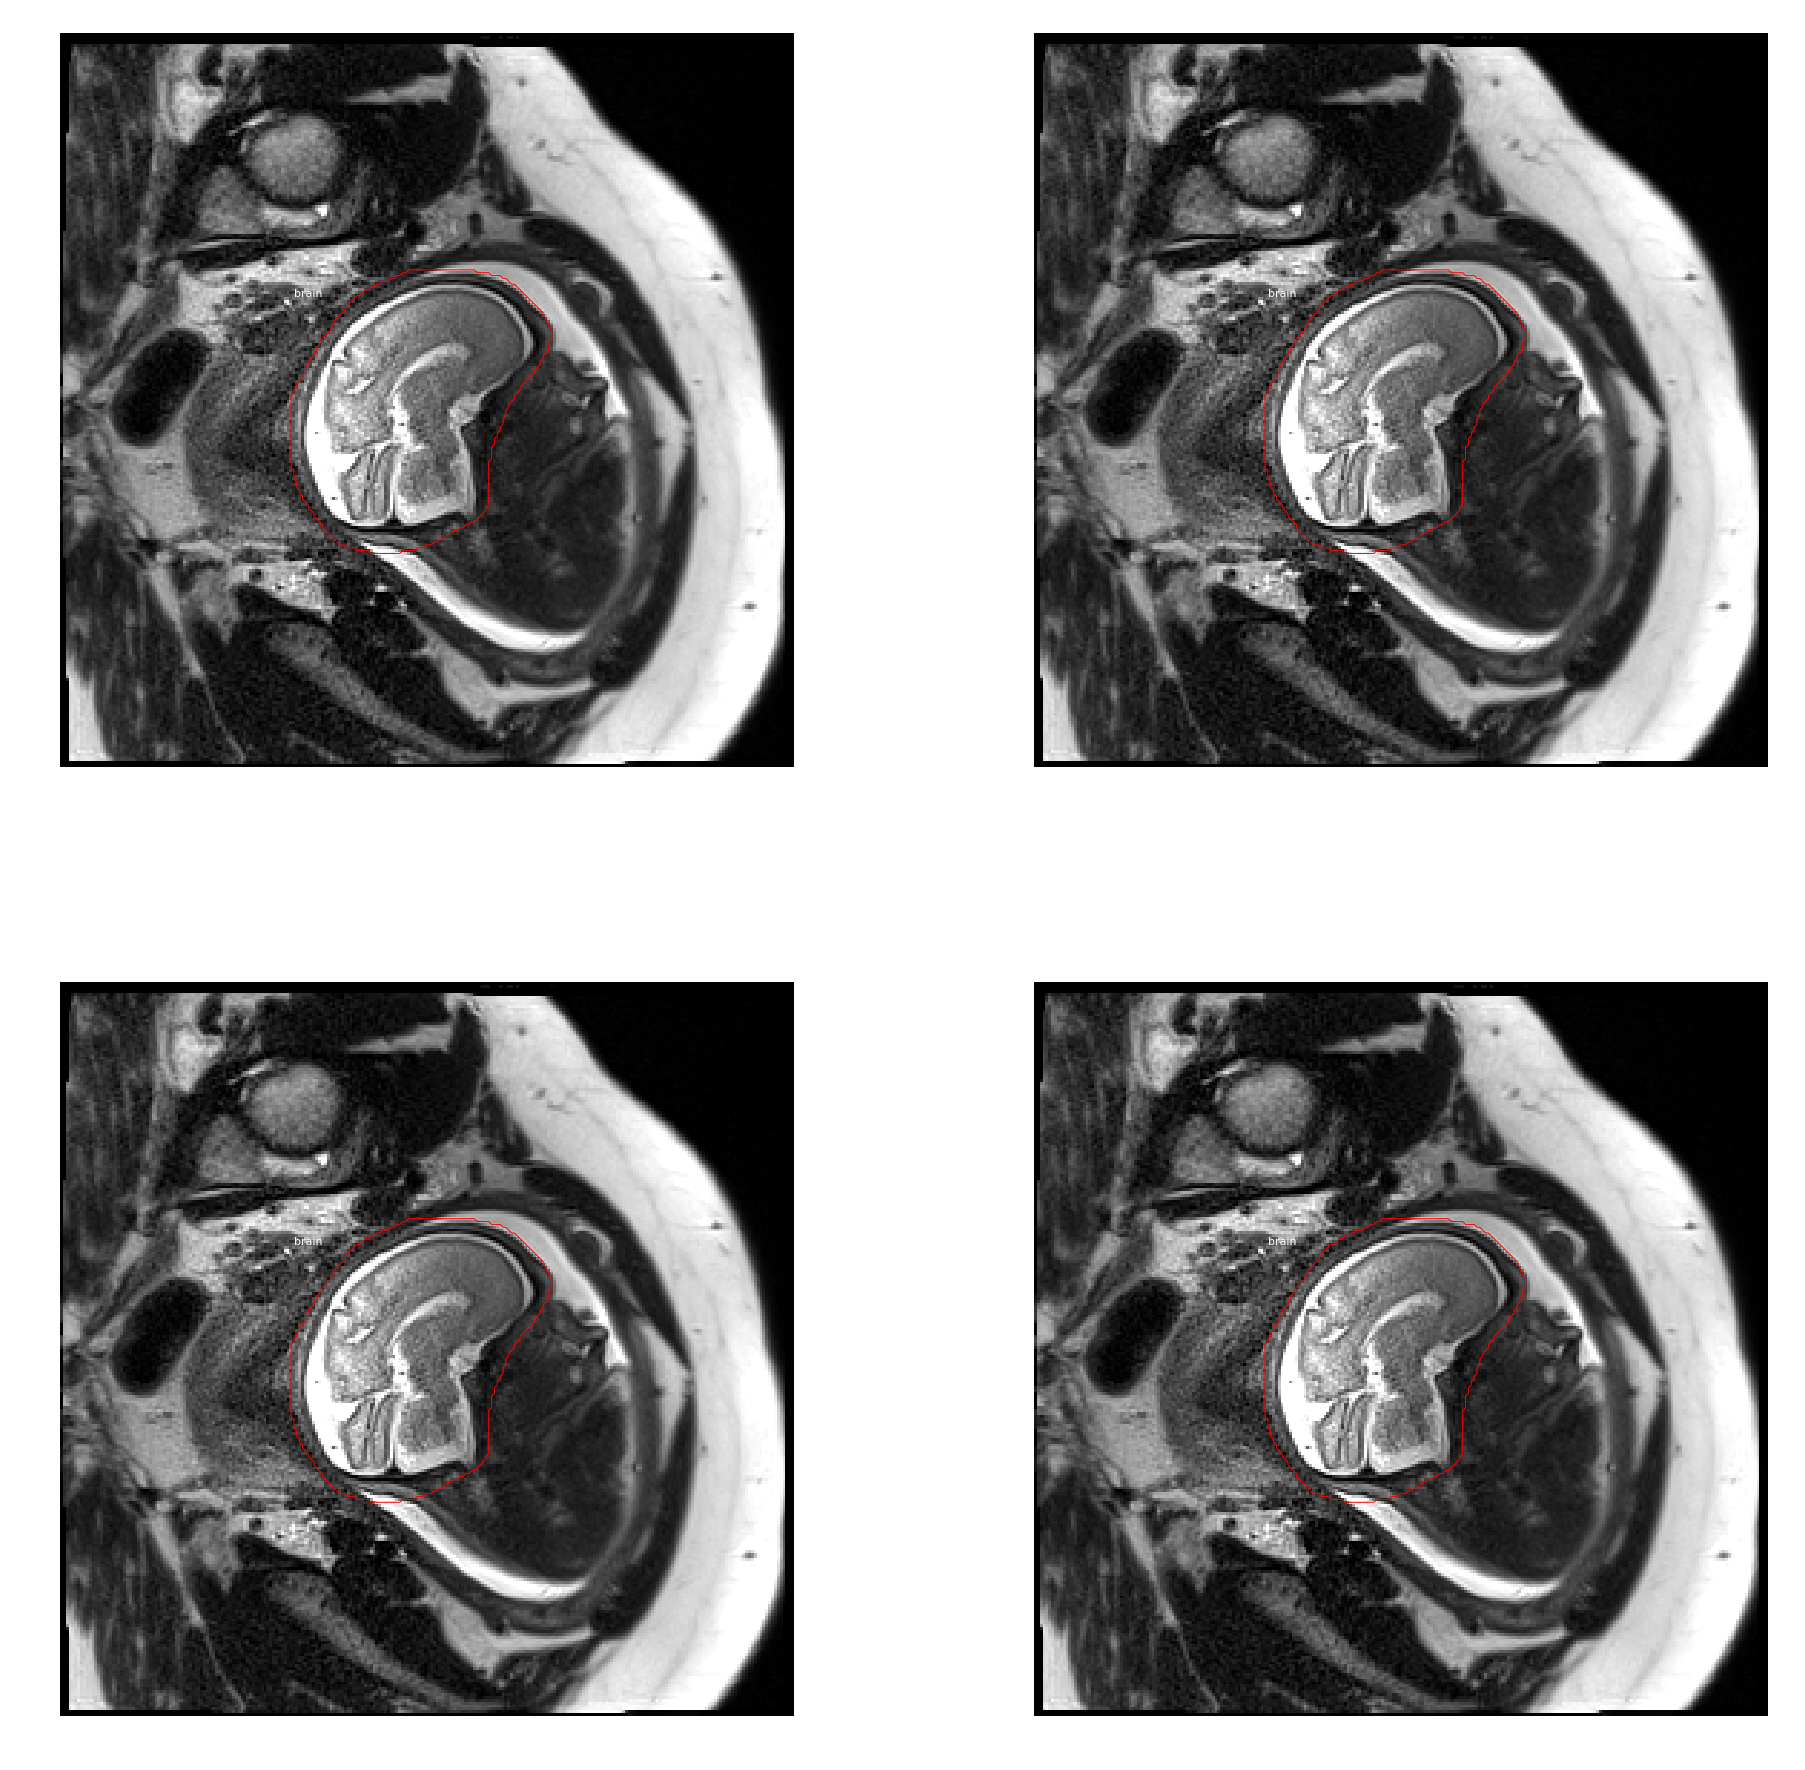

In [24]:
print('square')

# Load the image multiple times to show augmentations
limit = 4
image_id = np.random.choice(dataset.image_ids, 1)[0]
ax = get_ax(rows=2, cols=limit//2)
for i in range(limit):
    image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
        dataset, square_config, image_id, use_mini_mask=False)
    visualize.display_instances(image, bbox, mask, class_ids,
                                dataset.class_names, ax=ax[i//2, i % 2],
                                show_mask=False, show_bbox=False)

None


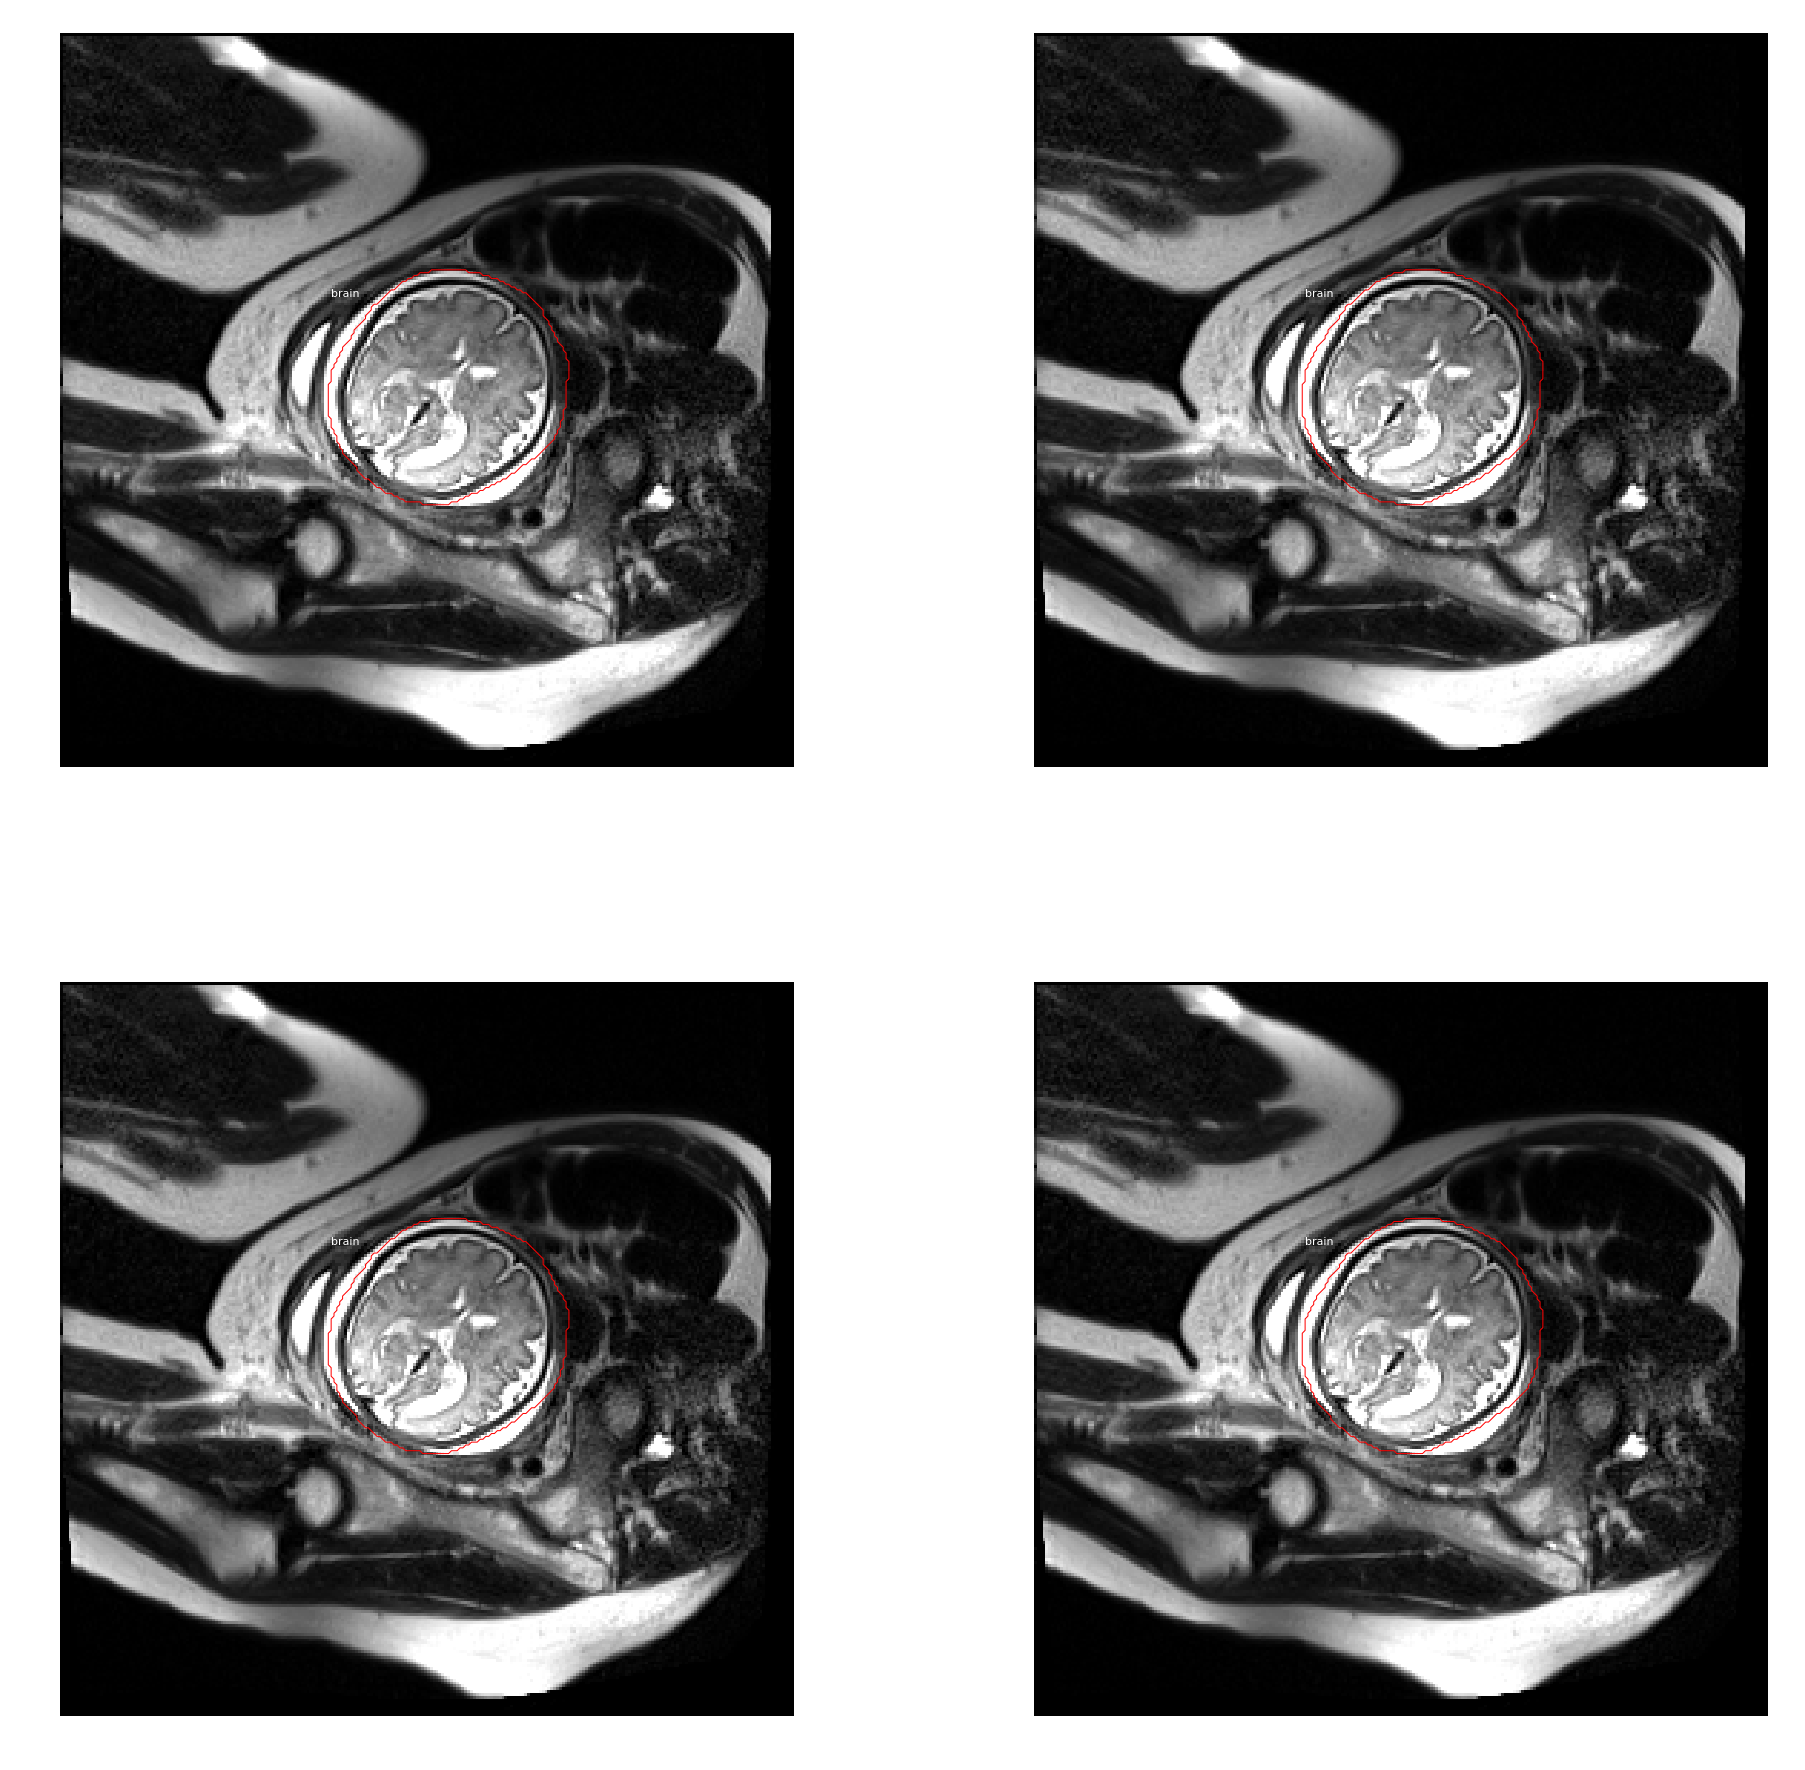

In [25]:
print('None')

# Load the image multiple times to show augmentations
limit = 4
image_id = np.random.choice(dataset.image_ids, 1)[0]
ax = get_ax(rows=2, cols=limit//2)
for i in range(limit):
    image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
        dataset, none_config, image_id, use_mini_mask=False)
    visualize.display_instances(image, bbox, mask, class_ids,
                                dataset.class_names, ax=ax[i//2, i % 2],
                                show_mask=False, show_bbox=False)


## Mini Masks

Instance binary masks can get large when training with high resolution images. For example, if training with 1024x1024 image then the mask of a single instance requires 1MB of memory (Numpy uses bytes for boolean values). If an image has 100 instances then that's 100MB for the masks alone.

To improve training speed, we optimize masks:

-  We store mask pixels that are inside the object bounding box, rather than a mask of the full image. Most objects are small compared to the image size, so we save space by not storing a lot of zeros around the object.
-  We resize the mask to a smaller size (e.g. 56x56). For objects that are larger than the selected size we lose a bit of accuracy. But most object annotations are not very accuracy to begin with, so this loss is negligable for most practical purposes. Thie size of the mini_mask can be set in the config class.

To visualize the effect of mask resizing, and to verify the code correctness, we visualize some examples.


image_id:  695
Original shape:  (256, 256, 3)
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint16
mask                     shape: (256, 256, 1)         min:    0.00000  max:  255.00000  uint16
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:   63.00000  max:  195.00000  int32


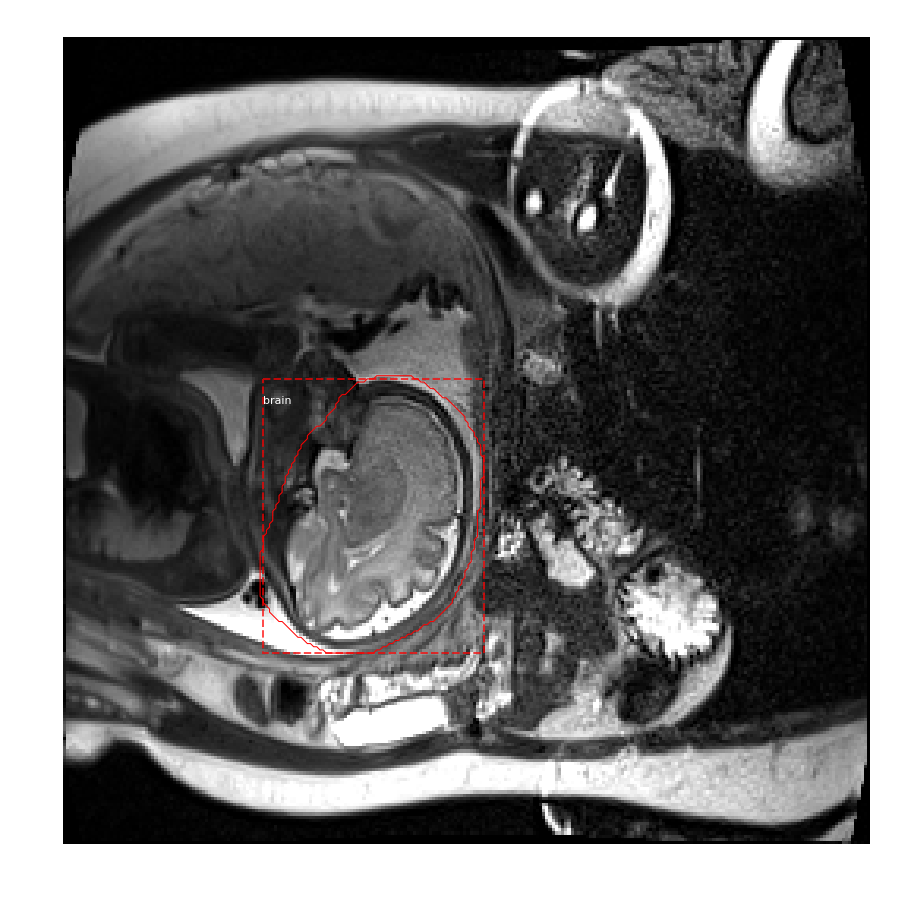

In [31]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding, _ = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id)
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint16
image_meta               shape: (14,)                 min:    0.00000  max: 5893.00000  int64
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:   97.00000  max:  219.00000  int32
mask                     shape: (256, 256, 1)         min:    0.00000  max:  255.00000  uint16


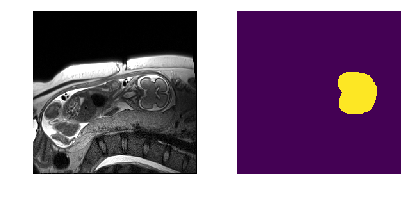

In [32]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

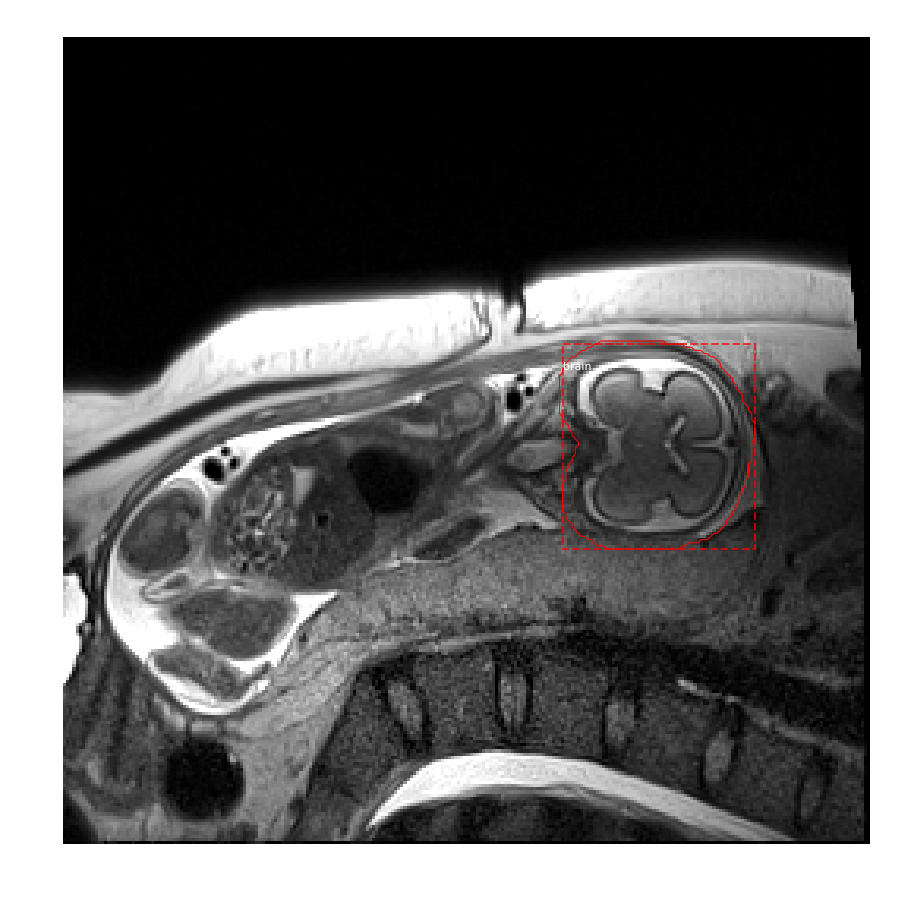

In [33]:
visualize.display_instances(image, bbox, mask, class_ids, 
                            dataset.class_names, show_mask=True)

mask                     shape: (56, 56, 1)           min:    0.00000  max:    1.00000  bool


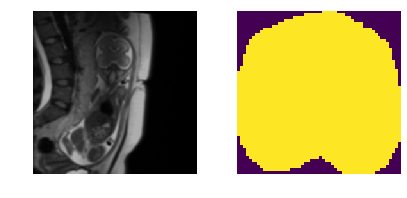

In [46]:
# Add augmentation and mask resizing.
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, augmentation=augmentation, use_mini_mask=True)
log("mask", mask)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

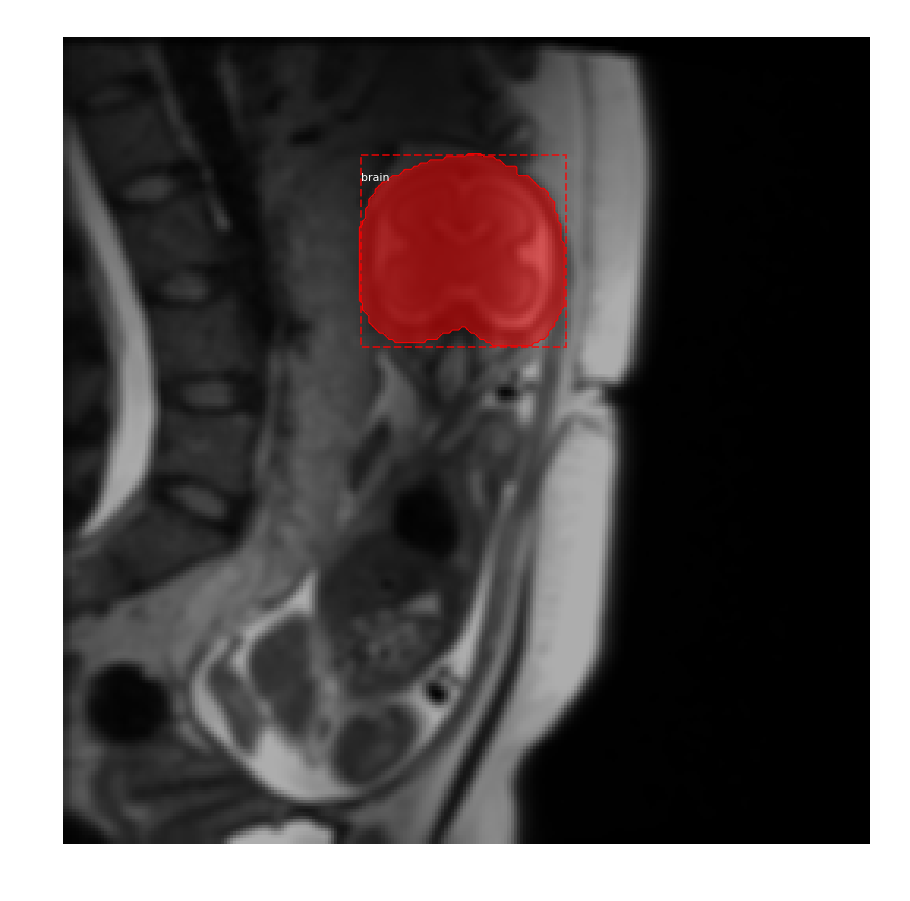

In [47]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)


## Anchors

For an FPN network, the anchors must be ordered in a way that makes it easy to match anchors to the output of the convolution layers that predict anchor scores and shifts.

-  Sort by pyramid level first. All anchors of the first level, then all of the second and so on. This makes it easier to separate anchors by level.
-  Within each level, sort anchors by feature map processing sequence. Typically, a convolution layer processes a feature map starting from top-left and moving right row by row.
-  For each feature map cell, pick any sorting order for the anchors of different ratios. Here we match the order of ratios passed to the function.



Count:  16320
Scales:  (16, 32, 64, 128)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 12288
Anchors in Level 1: 3072
Anchors in Level 2: 768
Anchors in Level 3: 192
Anchors in Level 4: 48
Level 0. Anchors:  12288  Feature map Shape: [64 64]
Level 1. Anchors:   3072  Feature map Shape: [32 32]
Level 2. Anchors:    768  Feature map Shape: [16 16]
Level 3. Anchors:    192  Feature map Shape: [8 8]
Level 4. Anchors:      0  Feature map Shape: [4 4]


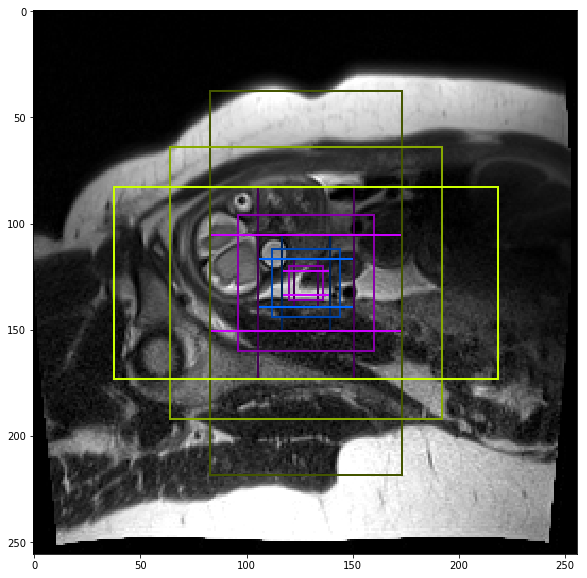

In [48]:
## Visualize anchors of one cell at the center of the feature map
# Load and display random image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, config, image_id)

# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, image.shape)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

# Display
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)

## Data Generator

In [49]:
# Create data generator
random_rois = 2000
g = modellib.data_generator(
    dataset, config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True,
    augmentation = augmentation)

In [50]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id)

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

rois                     shape: (4, 100, 4)           min:    0.00000  max:  255.00000  int32
mrcnn_class_ids          shape: (4, 100, 1)           min:    0.00000  max:    1.00000  int32
mrcnn_bbox               shape: (4, 100, 2, 4)        min:   -3.19901  max:    3.37564  float32
mrcnn_mask               shape: (4, 100, 28, 28, 2)   min:    0.00000  max:    1.00000  float32
gt_class_ids             shape: (4, 1)                min:    1.00000  max:    1.00000  int32
gt_boxes                 shape: (4, 1, 4)             min:   47.00000  max:  196.00000  int32
gt_masks                 shape: (4, 256, 256, 1)      min:    0.00000  max:    1.00000  bool
rpn_match                shape: (4, 16320, 1)         min:   -1.00000  max:    1.00000  int32
rpn_bbox                 shape: (4, 64, 4)            min:   -1.21534  max:    1.35967  float64
image_id:  4478


anchors                  shape: (16320, 4)            min:  -90.50967  max:  314.50967  float64
refined_anchors          shape: (1, 4)                min:  104.00000  max:  196.00000  float32
Positive anchors: 1
Negative anchors: 63
Neutral anchors: 16256
BG                     : 67
brain                  : 33


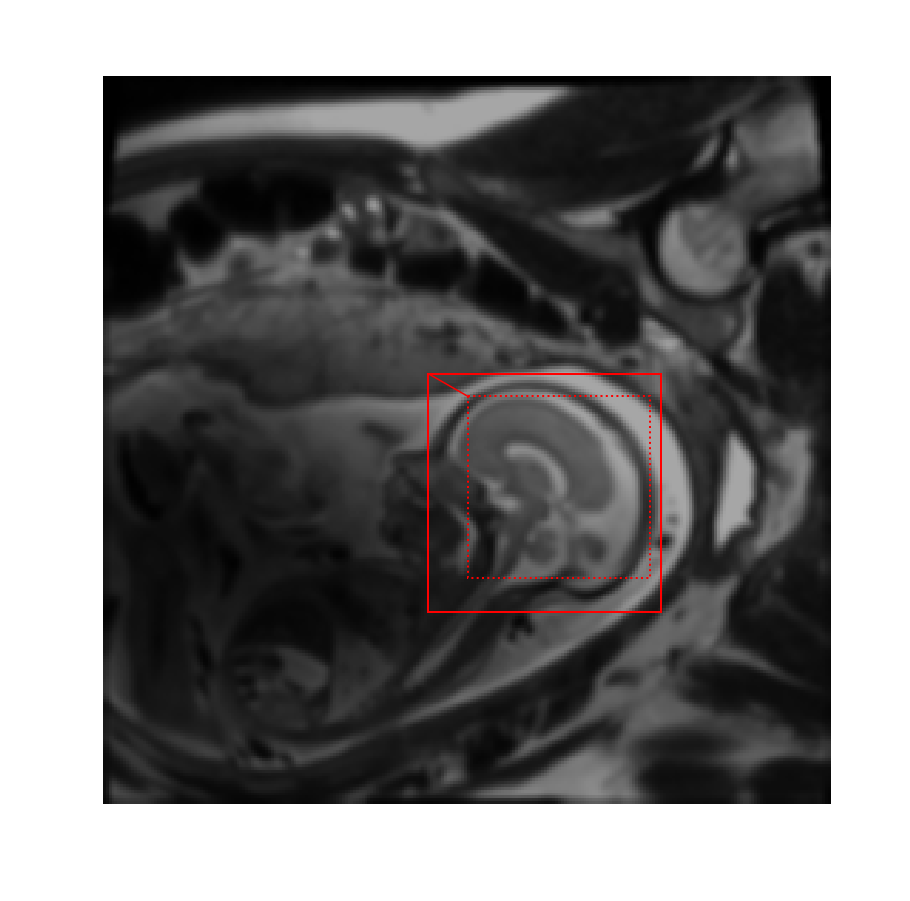

In [51]:


b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
fig, ax = plt.subplots(1, figsize=(16, 16))
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors, ax=ax)



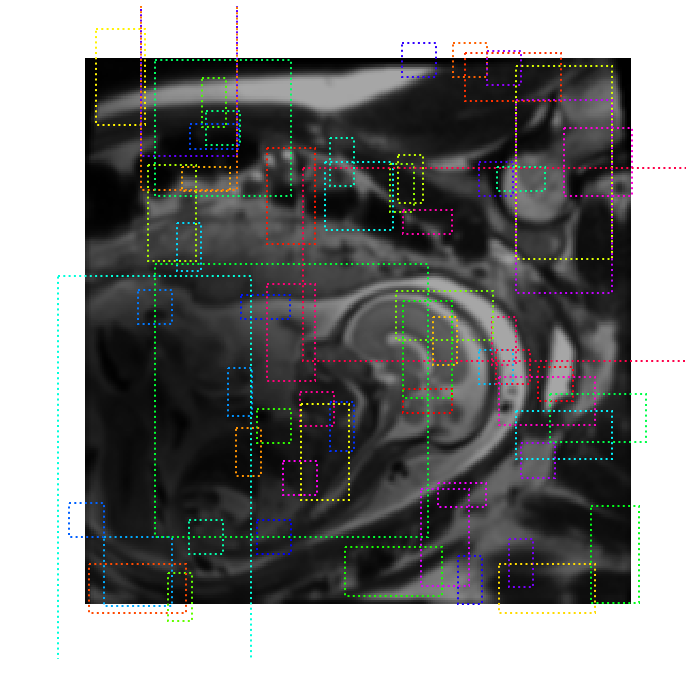

In [52]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

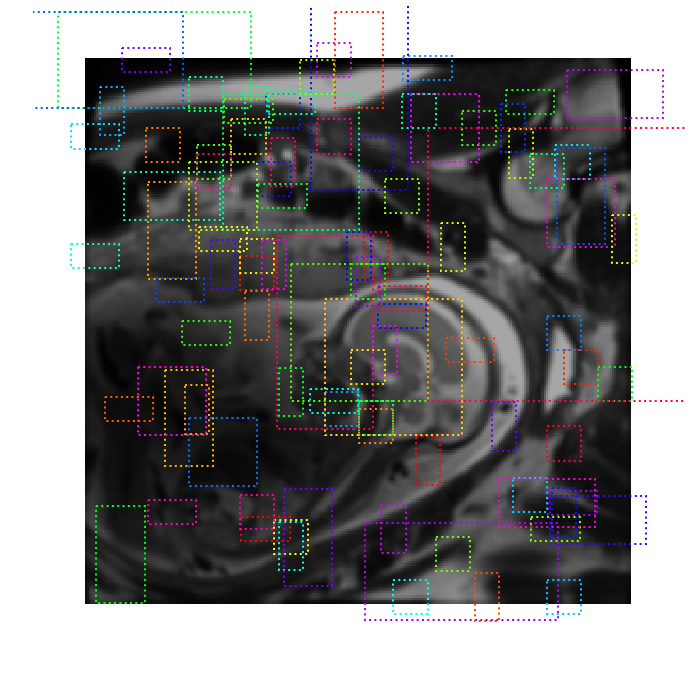

In [53]:

# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

## ROIs

Typically, the RPN network generates region proposals (a.k.a. Regions of Interest, or ROIs). The data generator has the ability to generate proposals as well for illustration and testing purposes. These are controlled by the random_rois parameter.

Positive ROIs:  33
Negative ROIs:  67
Positive Ratio: 0.33
Unique ROIs: 100 out of 100


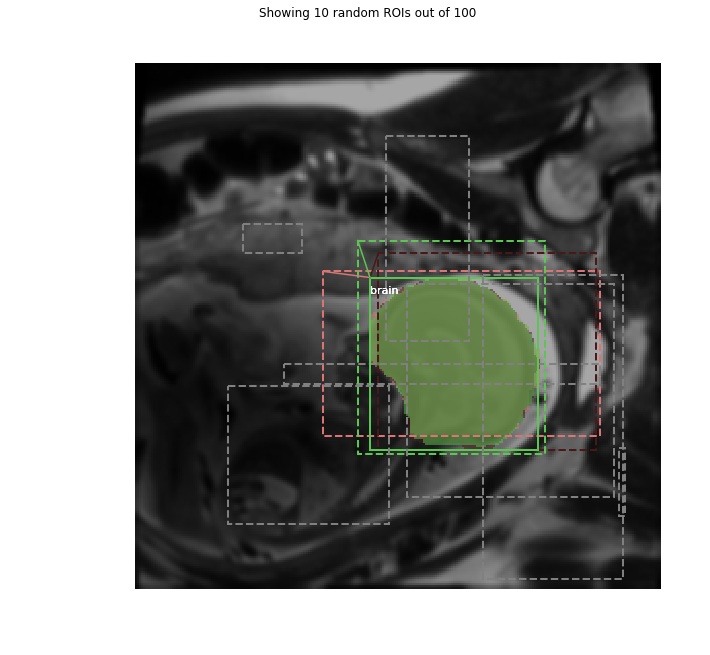

In [54]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))


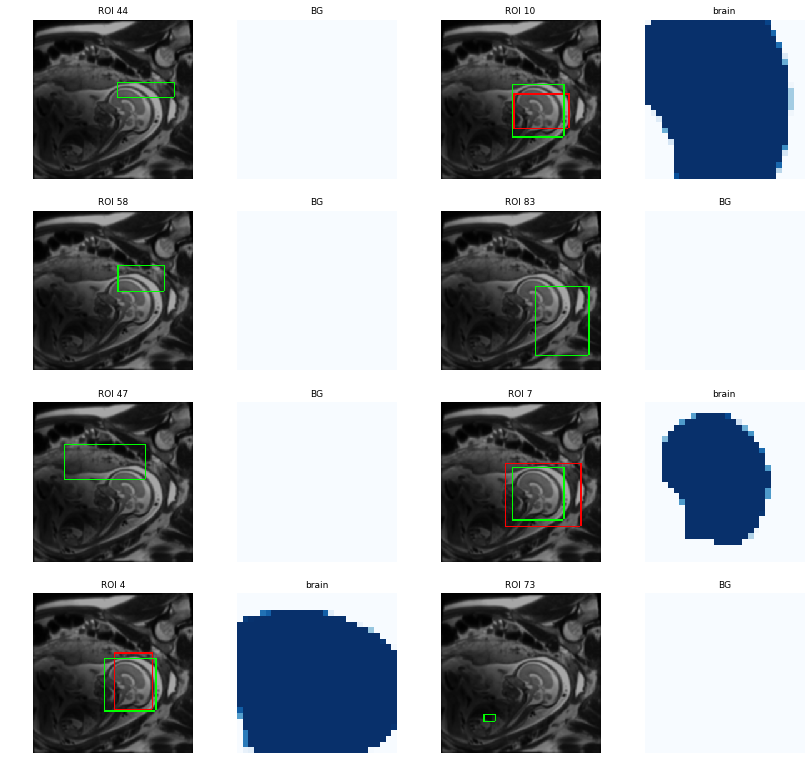

In [55]:
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [58]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.data_generator(
        dataset, config, shuffle=True, random_rois=10000, 
        batch_size=1, detection_targets=True, augmentation=augmentation)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

   33  0.33
   33  0.33
   33  0.33
   33  0.33
   33  0.33
   33  0.33
   33  0.33
   33  0.33
   33  0.33
   33  0.33
Average percent: 0.33
